In [258]:
#import pckages used

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

#Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics

#Statsmodel,VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 

In [259]:
# Read Data
LeadData=pd.read_csv('Leads.csv')
LeadData.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


## Data Cleaning:

In [260]:
# Get Info about data
LeadData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

In [261]:
# info shows many columns have null values ; lets Treat the null values

# Get % null values and 'Select' for each column
round(100*((LeadData.isnull() | LeadData.isin(['Select'])).sum())/len(LeadData.index),2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

In [262]:
#Function to get DataFrame for column value counts , its %, and converted sum for Non Null values 
#For NaNs it will show converted as 0 and can be ignored

def getColValCount(ColName):
    ColVals=[[],[],[],[]]
    ColVals[0]=LeadData[ColName].value_counts(dropna=False).index
    ColVals[1]=LeadData[ColName].value_counts(dropna=False).values
    ColVals[2]=(LeadData[ColName].value_counts(dropna=False).values/92.4).round(0)
    ColVals[3]=list(map(lambda x:LeadData.loc[LeadData[ColName]==x].Converted.sum(),ColVals[0]))
    ColVals=pd.DataFrame(ColVals).T
    ColVals.columns=['ColVals','Freq','%','Converted']
    return ColVals

In [263]:
### Analyse NULL and other values in 'Lead Source' column

#1) Google and google are two same values in different letter case. Change 'google' to 'Google'.
LeadData['Lead Source'].replace('google','Google',inplace=True)

#2) NaN values total =36 only 0.39% , hence remove rows with NULL
LeadData=LeadData.loc[~LeadData['Lead Source'].isnull()]

getColValCount('Lead Source')

,ColVals,Freq,%,Converted
0,Google,2873,31,1147
1,Direct Traffic,2543,28,818
2,Olark Chat,1755,19,448
3,Organic Search,1154,12,436
4,Reference,534,6,490
5,Welingak Website,142,2,140
6,Referral Sites,125,1,31
7,Facebook,55,1,13
8,bing,6,0,1
9,Click2call,4,0,3


In [264]:
# Columns TotalVisits, Page Views Per Visit, Last Activity have very little NULL values . 
# Hence deleting null rows in these columns.
LeadData=LeadData.loc[~LeadData['TotalVisits'].isnull()]
LeadData=LeadData.loc[~LeadData['Page Views Per Visit'].isnull()]
LeadData=LeadData.loc[~LeadData['Last Activity'].isnull()]

In [265]:
# Get % null values and 'Select' for each column
round(100*((LeadData.isnull() | LeadData.isin(['Select'])).sum())/len(LeadData.index),2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.00
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       0.00
Total Time Spent on Website                       0.00
Page Views Per Visit                              0.00
Last Activity                                     0.00
Country                                          25.30
Specialization                                   36.17
How did you hear about X Education               78.09
What is your current occupation                  29.57
What matters most to you in choosing a course    29.78
Search                                            0.00
Magazine                                          0.00
Newspaper 

### There are few column which have very little significance wrt to our problem , like Location (= Country,City). We drop these columns.

### There are few columns which have too much of missing values (NULL,Select) like 'Lead Profile' ,'How did you hear about X Education'.

In [266]:
# Drop the columns discussed above
LeadData.drop(columns=['Country','City','Lead Profile','How did you hear about X Education'],inplace=True)
LeadData.shape

(9074, 33)

In [267]:
# Lets check Tags columns
getColValCount('Tags')

,ColVals,Freq,%,Converted
0,NaN,3327,36,0
1,Will revert after reading the email,2016,22,1957
2,Ringing,1187,13,34
3,Interested in other courses,509,6,13
4,Already a student,465,5,3
5,Closed by Horizzon,301,3,299
6,switched off,240,3,4
7,Busy,185,2,105
8,Lost to EINS,172,2,168
9,Not doing further education,145,2,1


### Tags is also not adding much information for our problem and as such 36% are NULL values. Categories are arbitrary not giving exact indication of conversion. Deleteing this column.

In [268]:
#Delete Tags column
LeadData.drop(columns=['Tags'],inplace=True)
LeadData.shape

(9074, 32)

In [269]:
# Study column 'Lead Quality'
getColValCount('Lead Quality')

,ColVals,Freq,%,Converted
0,NaN,4720,51,0
1,Might be,1519,16,1150
2,Not Sure,1086,12,266
3,Worst,601,7,12
4,High in Relevance,592,6,558
5,Low in Relevance,556,6,455


### For column 'Lead Quality' , NULLs is 51% while other values do not get good or expected indicators of conversions Eg: conversions for 'High in Relevance' should have been much more than 'Might be' , similarly conversions of 'Low in Relevance' is almost similar to 'High in Relevance'.
### Hence deleting the column.

In [270]:
# Delete column 'Lead Quality'
LeadData.drop(columns=['Lead Quality'],inplace=True)
LeadData.shape

(9074, 31)

In [271]:
# Lets check again: Get % null values and 'Select' for each column
round(100*((LeadData.isnull() | LeadData.isin(['Select'])).sum())/len(LeadData.index),2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.00
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       0.00
Total Time Spent on Website                       0.00
Page Views Per Visit                              0.00
Last Activity                                     0.00
Specialization                                   36.17
What is your current occupation                  29.57
What matters most to you in choosing a course    29.78
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

In [272]:
# Lets check Asymmetrique columns
a1=getColValCount('Asymmetrique Activity Score')
a2=getColValCount('Asymmetrique Profile Score')

print(a1)
print(a2)

    ColVals    Freq     %  Converted
0       NaN  4153.0  45.0        0.0
1      14.0  1704.0  18.0      650.0
2      15.0  1284.0  14.0      815.0
3      13.0   751.0   8.0       98.0
4      16.0   467.0   5.0      228.0
5      17.0   348.0   4.0       17.0
6      12.0   196.0   2.0       23.0
7      11.0    95.0   1.0        7.0
8      10.0    57.0   1.0        3.0
9       9.0     9.0   0.0        0.0
10     18.0     5.0   0.0        0.0
11      8.0     4.0   0.0        0.0
12      7.0     1.0   0.0        0.0
    ColVals    Freq     %  Converted
0       NaN  4153.0  45.0        0.0
1      15.0  1735.0  19.0      489.0
2      18.0  1066.0  12.0      379.0
3      16.0   583.0   6.0      231.0
4      17.0   566.0   6.0      249.0
5      20.0   298.0   3.0      209.0
6      19.0   224.0   2.0      166.0
7      14.0   220.0   2.0       57.0
8      13.0   198.0   2.0       46.0
9      12.0    22.0   0.0       10.0
10     11.0     9.0   0.0        5.0


### Asymmetrique scores columns have 45% NULL values and also the categories are very diverse with very distributed conversion rates. Cannot find a logical imputation way for the score columns. With many doubts and NULLs , dropping these columns.

In [273]:
# Delete Asymmetrique Score columns
LeadData.drop(columns=['Asymmetrique Activity Score','Asymmetrique Profile Score'],inplace=True)
LeadData.shape

(9074, 29)

### Asymmetrique Index columns have clear defined categories and high conversion rates as well for few categories. The columns look important , so we need to impute the NULL values.

In [274]:
# Get Frequency and conversion information for two Asymmetrique Index columns
a3=getColValCount('Asymmetrique Activity Index')
a4=getColValCount('Asymmetrique Profile Index')
print(a3)
print()
print(a4)

     ColVals  Freq   % Converted
0        NaN  4153  45         0
1  02.Medium  3739  40      1563
2    01.High   820   9       245
3     03.Low   362   4        33

     ColVals  Freq   % Converted
0        NaN  4153  45         0
1  02.Medium  2736  30       823
2    01.High  2154  23      1003
3     03.Low    31   0        15


### Deleting column Asymmetrique Profile Index as it shows comparable conversion rate for almost comparable frequency distribution between Medium and High.
### Imputing null values in Asymmetrique Activity Index with highest frequency or Mode value as Mode(Highest frequency) is way too high compared to next highest frequency

In [275]:
# Delete Asymmetrique Profile Index
LeadData.drop(columns=['Asymmetrique Profile Index'],inplace=True)
LeadData.shape

(9074, 28)

In [276]:
# Impute NULL values with Mode in Asymmetrique Activity Index
IndexMode=LeadData['Asymmetrique Activity Index'].mode() # Select Mode
LeadData['Asymmetrique Activity Index'].fillna(IndexMode[0],inplace=True)

# Remove the prefixes 01.,02.,03. from the values
LeadData['Asymmetrique Activity Index']=LeadData['Asymmetrique Activity Index'].apply(lambda x:x[3:])

#Check frequency and NULLs
LeadData['Asymmetrique Activity Index'].value_counts(dropna=False)


Medium    7892
High       820
Low        362
Name: Asymmetrique Activity Index, dtype: int64

In [277]:
# Lets check again: Get % null values and 'Select' for each column
round(100*((LeadData.isnull() | LeadData.isin(['Select'])).sum().sort_values(ascending=False))/len(LeadData.index),2)

Specialization                                   36.17
What matters most to you in choosing a course    29.78
What is your current occupation                  29.57
A free copy of Mastering The Interview            0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.00
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       0.00
Total Time Spent on Website                       0.00
Page Views Per Visit                              0.00
Last Activity                                     0.00
Last Notable Activity                             0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Educatio

In [278]:
# Get information abount Specialization column
getColValCount('Specialization')


,ColVals,Freq,%,Converted
0,Select,1851,20,750
1,NaN,1431,15,0
2,Finance Management,959,10,422
3,Human Resource Management,837,9,380
4,Marketing Management,823,9,397
5,Operations Management,499,5,234
6,Business Administration,399,4,175
7,IT Projects Management,366,4,140
8,Supply Chain Management,346,4,148
9,"Banking, Investment And Insurance",335,4,164


### The specialisation has too many categories and also NaNs are 35% (NaN+Select).Cannot impute NULLs with mode as other categories are also have comparable frequency. Hence deleting this column.

In [279]:
# Delete Specialization column
LeadData.drop(columns=['Specialization'],inplace=True)
LeadData.shape

(9074, 27)

In [280]:
#get info for column 'What matters most to you in choosing a course'
getColValCount('What matters most to you in choosing a course')

,ColVals,Freq,%,Converted
0,Better Career Prospects,6370,69,3064
1,NaN,2702,29,0
2,Other,1,0,0
3,Flexibility & Convenience,1,0,1


### There is >29% Null and also almost No Variance in data.One category explains all conversions. Hence no use of this column and deleting it.

In [281]:
# Delete 'What matters most to you in choosing a course' column
LeadData.drop(columns=['What matters most to you in choosing a course'],inplace=True)
LeadData.shape

(9074, 26)

In [282]:
# get info for column 'What is your current occupation'
getColValCount('What is your current occupation')

,ColVals,Freq,%,Converted
0,Unemployed,5476,59,2346
1,NaN,2683,29,0
2,Working Professional,677,7,622
3,Student,206,2,74
4,Other,15,0,9
5,Housewife,9,0,9
6,Businessman,8,0,5


### There is >29% Null and also almost No Variance in data.The two categories expectedly explains whole population and all conversions while other categories solve no purpose.Imputing by mode may make  data very biased for unemployed. Hence dropping this column.

In [283]:
# Delete 'What is your current occupation' column
LeadData.drop(columns=['What is your current occupation'],inplace=True)
LeadData.shape

(9074, 25)

In [284]:
# Columns Prospect ID and Lead Number do not add any value for modelling. Hence deleting these columns
LeadData.drop(columns=['Prospect ID','Lead Number'],inplace=True)
LeadData.shape

(9074, 23)

In [285]:
# Renaming column having long names for easy recognition in further analysis.
LeadData.rename(columns={"Total Time Spent on Website":"TimeOnWebsite","Page Views Per Visit":"PVPV","A free copy of Mastering The Interview":"InterviewFreeCopy","Receive More Updates About Our Courses":"GetMoreUpdates","Update me on Supply Chain Content":"GetSCContent","Get updates on DM Content":"GetDMContent","I agree to pay the amount through cheque":"ChequePayment"},inplace=True)
LeadData.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'TimeOnWebsite', 'PVPV', 'Last Activity',
       'Search', 'Magazine', 'Newspaper Article', 'X Education Forums',
       'Newspaper', 'Digital Advertisement', 'Through Recommendations',
       'GetMoreUpdates', 'GetSCContent', 'GetDMContent',
       'Asymmetrique Activity Index', 'ChequePayment', 'InterviewFreeCopy',
       'Last Notable Activity'],
      dtype='object')

In [286]:
# Lets check again: Get % null values and 'Select' for each column
round(100*((LeadData.isnull() | LeadData.isin(['Select'])).sum().sort_values(ascending=False))/len(LeadData.index),2)

Last Notable Activity          0.0
Magazine                       0.0
Lead Source                    0.0
Do Not Email                   0.0
Do Not Call                    0.0
Converted                      0.0
TotalVisits                    0.0
TimeOnWebsite                  0.0
PVPV                           0.0
Last Activity                  0.0
Search                         0.0
Newspaper Article              0.0
InterviewFreeCopy              0.0
X Education Forums             0.0
Newspaper                      0.0
Digital Advertisement          0.0
Through Recommendations        0.0
GetMoreUpdates                 0.0
GetSCContent                   0.0
GetDMContent                   0.0
Asymmetrique Activity Index    0.0
ChequePayment                  0.0
Lead Origin                    0.0
dtype: float64

### Lets reveiw all other categorical variables for suitability to include in modelling.

In [287]:
print(getColValCount('Do Not Email'))
# This column can be kept as 'Yes' yeilds good % results though frequency is low.

print(getColValCount('Do Not Call'))
#This column can be deleted , as almost all responses are 'no'. No value addition. 

print(getColValCount('Magazine'))
print(getColValCount('Search'))
print(getColValCount('Newspaper Article'))
print(getColValCount('X Education Forums'))
print(getColValCount('Newspaper'))
print(getColValCount('Digital Advertisement'))
print(getColValCount('Through Recommendations'))
# All above columns have more than 98% responses as 'No' and hence do not yield any value.Deleteing these columns.

print(getColValCount('GetMoreUpdates'))
print(getColValCount('GetSCContent'))
print(getColValCount('GetDMContent'))
print(getColValCount('ChequePayment'))
#All above columns have only response as 'No' and hence do not yield any value.Deleteing these columns.

#Delete above mentioned columns
LeadData.drop(columns=['Do Not Call','Magazine','Search','Newspaper Article','X Education Forums','Newspaper','Digital Advertisement','Through Recommendations','GetMoreUpdates','GetSCContent','GetDMContent','ChequePayment'],inplace=True)
LeadData.shape

  ColVals  Freq   % Converted
0      No  8358  90      3331
1     Yes   716   8       104
  ColVals  Freq   % Converted
0      No  9072  98      3433
1     Yes     2   0         2
  ColVals  Freq   % Converted
0      No  9074  98      3435
  ColVals  Freq   % Converted
0      No  9060  98      3430
1     Yes    14   0         5
  ColVals  Freq   % Converted
0      No  9072  98      3434
1     Yes     2   0         1
  ColVals  Freq   % Converted
0      No  9073  98      3435
1     Yes     1   0         0
  ColVals  Freq   % Converted
0      No  9073  98      3435
1     Yes     1   0         0
  ColVals  Freq   % Converted
0      No  9070  98      3434
1     Yes     4   0         1
  ColVals  Freq   % Converted
0      No  9067  98      3430
1     Yes     7   0         5
  ColVals  Freq   % Converted
0      No  9074  98      3435
  ColVals  Freq   % Converted
0      No  9074  98      3435
  ColVals  Freq   % Converted
0      No  9074  98      3435
  ColVals  Freq   % Converted
0      No 

(9074, 11)

In [288]:
# column 'Last Notable Activity' looks fine an I leave it as is

print(getColValCount('Last Notable Activity'))


                         ColVals  Freq   % Converted
0                       Modified  3267  35       680
1                   Email Opened  2823  31      1042
2                       SMS Sent  2152  23      1489
3        Page Visited on Website   318   3        93
4        Olark Chat Conversation   183   2        25
5             Email Link Clicked   173   2        45
6                  Email Bounced    60   1         9
7                   Unsubscribed    45   0        12
8                    Unreachable    32   0        22
9       Had a Phone Conversation    14   0        13
10             Email Marked Spam     2   0         2
11     Form Submitted on Website     1   0         0
12                Email Received     1   0         1
13            Approached upfront     1   0         1
14  View in browser link Clicked     1   0         0
15        Resubscribed to emails     1   0         1


In [289]:
# Also this column looks almost same as 'Last Activity' and hence one of them should be dropped to avoid confusion.
#Dropping column 'Last Activity'
LeadData.drop(columns=['Last Activity'],inplace=True)
LeadData.shape

(9074, 10)

### There are many categorical values . For Logistic Regression these need to be converted to continuous numerical variables using dummy variables.

In [290]:
#Get final original columns retained in data set
LeadData.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Converted',
       'TotalVisits', 'TimeOnWebsite', 'PVPV', 'Asymmetrique Activity Index',
       'InterviewFreeCopy', 'Last Notable Activity'],
      dtype='object')

In [291]:
# Lets also evaluate 'InterviewFreeCopy'
getColValCount('InterviewFreeCopy')

#This column looks fine and can be retained.

,ColVals,Freq,%,Converted
0,No,6186,67,2405
1,Yes,2888,31,1030


In [292]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
DummyVars = pd.get_dummies(LeadData[['Lead Origin','Lead Source','Do Not Email','Asymmetrique Activity Index','InterviewFreeCopy','Last Notable Activity']], drop_first=False)
DummyVars.columns


Index(['Lead Origin_API', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Lead Add Form', 'Lead Origin_Lead Import',
       'Lead Source_Click2call', 'Lead Source_Direct Traffic',
       'Lead Source_Facebook', 'Lead Source_Google', 'Lead Source_Live Chat',
       'Lead Source_NC_EDM', 'Lead Source_Olark Chat',
       'Lead Source_Organic Search', 'Lead Source_Pay per Click Ads',
       'Lead Source_Press_Release', 'Lead Source_Reference',
       'Lead Source_Referral Sites', 'Lead Source_Social Media',
       'Lead Source_WeLearn', 'Lead Source_Welingak Website',
       'Lead Source_bing', 'Lead Source_blog', 'Lead Source_testone',
       'Lead Source_welearnblog_Home', 'Lead Source_youtubechannel',
       'Do Not Email_No', 'Do Not Email_Yes',
       'Asymmetrique Activity Index_High', 'Asymmetrique Activity Index_Low',
       'Asymmetrique Activity Index_Medium', 'InterviewFreeCopy_No',
       'InterviewFreeCopy_Yes', 'Last Notable Activity_Approached upfront',
       'La

In [293]:
#Dropping columns with least frequency,as we need one less dummy column than number of categories for each original column
DummyVars.drop(columns=['Lead Origin_Lead Import','Lead Source_NC_EDM','Do Not Email_Yes','Asymmetrique Activity Index_Low','InterviewFreeCopy_Yes','Last Notable Activity_View in browser link Clicked'],inplace=True)
DummyVars.columns

Index(['Lead Origin_API', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Lead Add Form', 'Lead Source_Click2call',
       'Lead Source_Direct Traffic', 'Lead Source_Facebook',
       'Lead Source_Google', 'Lead Source_Live Chat', 'Lead Source_Olark Chat',
       'Lead Source_Organic Search', 'Lead Source_Pay per Click Ads',
       'Lead Source_Press_Release', 'Lead Source_Reference',
       'Lead Source_Referral Sites', 'Lead Source_Social Media',
       'Lead Source_WeLearn', 'Lead Source_Welingak Website',
       'Lead Source_bing', 'Lead Source_blog', 'Lead Source_testone',
       'Lead Source_welearnblog_Home', 'Lead Source_youtubechannel',
       'Do Not Email_No', 'Asymmetrique Activity Index_High',
       'Asymmetrique Activity Index_Medium', 'InterviewFreeCopy_No',
       'Last Notable Activity_Approached upfront',
       'Last Notable Activity_Email Bounced',
       'Last Notable Activity_Email Link Clicked',
       'Last Notable Activity_Email Marked Spam',
      

In [294]:
# Concatenate DummyVars with main dataframe LeadData, and drop categorocal variables

#Concatenate Data Frames
LeadDataDummy=pd.concat([LeadData,DummyVars],axis=1)

#Drop categorical variables/columns
LeadDataDummy.drop(columns=['Lead Origin','Lead Source','Do Not Email','Asymmetrique Activity Index','InterviewFreeCopy','Last Notable Activity'],inplace=True)
print(LeadDataDummy.shape)
print(LeadDataDummy.columns)

(9074, 45)
Index(['Converted', 'TotalVisits', 'TimeOnWebsite', 'PVPV', 'Lead Origin_API',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Source_Click2call', 'Lead Source_Direct Traffic',
       'Lead Source_Facebook', 'Lead Source_Google', 'Lead Source_Live Chat',
       'Lead Source_Olark Chat', 'Lead Source_Organic Search',
       'Lead Source_Pay per Click Ads', 'Lead Source_Press_Release',
       'Lead Source_Reference', 'Lead Source_Referral Sites',
       'Lead Source_Social Media', 'Lead Source_WeLearn',
       'Lead Source_Welingak Website', 'Lead Source_bing', 'Lead Source_blog',
       'Lead Source_testone', 'Lead Source_welearnblog_Home',
       'Lead Source_youtubechannel', 'Do Not Email_No',
       'Asymmetrique Activity Index_High',
       'Asymmetrique Activity Index_Medium', 'InterviewFreeCopy_No',
       'Last Notable Activity_Approached upfront',
       'Last Notable Activity_Email Bounced',
       'Last Notable Activity_Email 

### Check outliers for 3 original columns 'TotalVisits', 'TimeOnWebsite', 'PVPV'

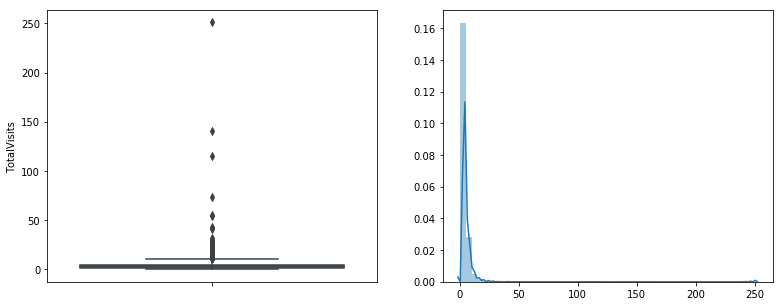

In [295]:
# Check outliers for column TotalVisits
plt.figure(figsize=(13,5))
plt.subplot(121)
sns.boxplot(y='TotalVisits',data=LeadDataDummy[['TotalVisits','Converted']])
plt.subplot(122)
sns.distplot(LeadDataDummy[['TotalVisits']])
plt.show()

In [296]:
#Check the description with percentiles.
LeadDataDummy[['TotalVisits']].describe(percentiles =[0.9,0.95])

,TotalVisits
count,9074.000000
mean,3.456028
std,4.858802
min,0.000000
50%,3.000000
90%,7.000000
95%,10.000000
max,251.000000


(9074, 2)


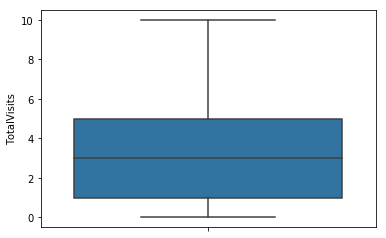

In [297]:
# Try capping with few percentiles in 95% to 99% , quantile=95% looks to be a good value to CAP 
q=LeadDataDummy['TotalVisits'].quantile(0.95)
TV=LeadDataDummy.loc[:,['TotalVisits','Converted']]

# Cap at 95%
TV['TotalVisits']=TV['TotalVisits'].apply(lambda x:x if x<q else q)
sns.boxplot(y='TotalVisits',data=TV)
print(TV.shape)

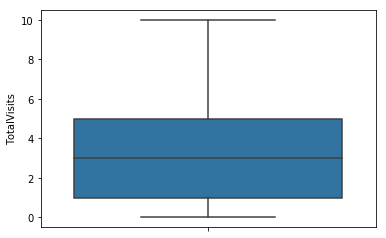

(9074, 45)


In [298]:
#cap original variable at 95%
LeadDataDummy['TotalVisits']=LeadDataDummy['TotalVisits'].apply(lambda x:x if x<q else q)
sns.boxplot(y='TotalVisits',data=LeadDataDummy)
plt.show()
print(LeadDataDummy.shape)

### The outliers are now handled for TotalVisits with 95% data retained. Trying CAPping first

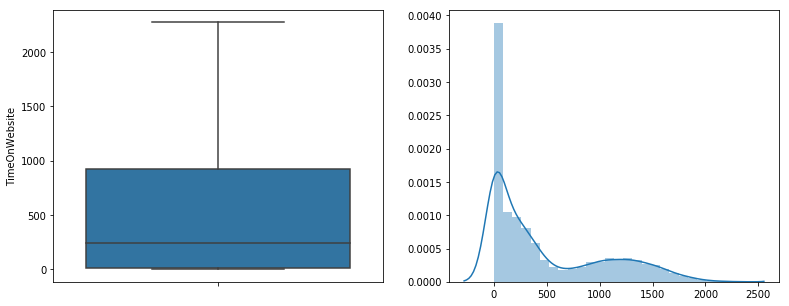

In [299]:
# Check outliers for column 'TimeOnWebsite'. There is no outlier.
plt.figure(figsize=(13,5))
plt.subplot(121)
sns.boxplot(y='TimeOnWebsite',data=LeadDataDummy[['TimeOnWebsite','Converted']])
plt.subplot(122)
sns.distplot(LeadDataDummy[['TimeOnWebsite']])
plt.show()


In [300]:
# Check for data shape as review
LeadDataDummy.shape

(9074, 45)

In [301]:
#Check the description with percentiles.
LeadDataDummy[['TimeOnWebsite']].describe(percentiles =[0.9,0.97,0.99])

,TimeOnWebsite
count,9074.000000
mean,482.887481
std,545.256560
min,0.000000
50%,246.000000
90%,1373.000000
97%,1655.000000
99%,1839.000000
max,2272.000000


### Outliers removed for column 'TimeOnWebsite'. No treatment required for now.

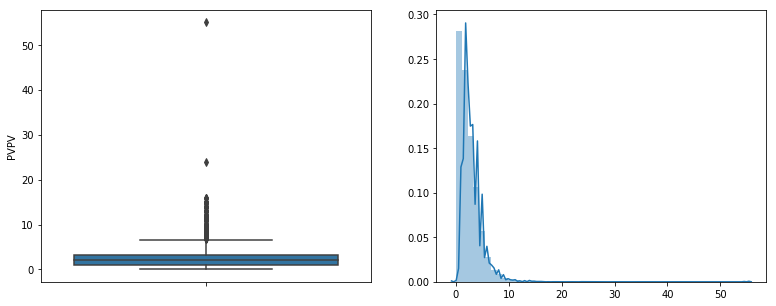

In [302]:
# Check outliers for column 'PVPV'
plt.figure(figsize=(13,5))
plt.subplot(121)
sns.boxplot(y='PVPV',data=LeadDataDummy[['PVPV','Converted']])
plt.subplot(122)
sns.distplot(LeadDataDummy[['PVPV']])
plt.show()


In [303]:
#Check the description with percentiles.
LeadDataDummy[['PVPV']].describe(percentiles =[0.9,0.97,0.99])

,PVPV
count,9074.000000
mean,2.370151
std,2.160871
min,0.000000
50%,2.000000
90%,5.000000
97%,7.000000
99%,9.000000
max,55.000000


In [304]:
# Cap at quantile=96%
q=LeadDataDummy['PVPV'].quantile(0.96)
print(q)

6.0


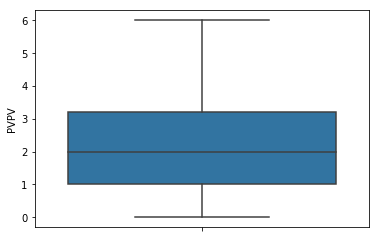

In [305]:
#Capping at 96%
LeadDataDummy['PVPV']=LeadDataDummy['PVPV'].apply(lambda x:x if x<q else q)
sns.boxplot(y='PVPV',data=LeadDataDummy)
plt.show()

In [306]:
LeadDataDummy.shape

(9074, 45)

### Outliers are treated with capping. 
### Lets us look at highly correlated columns and see if they can be removed.

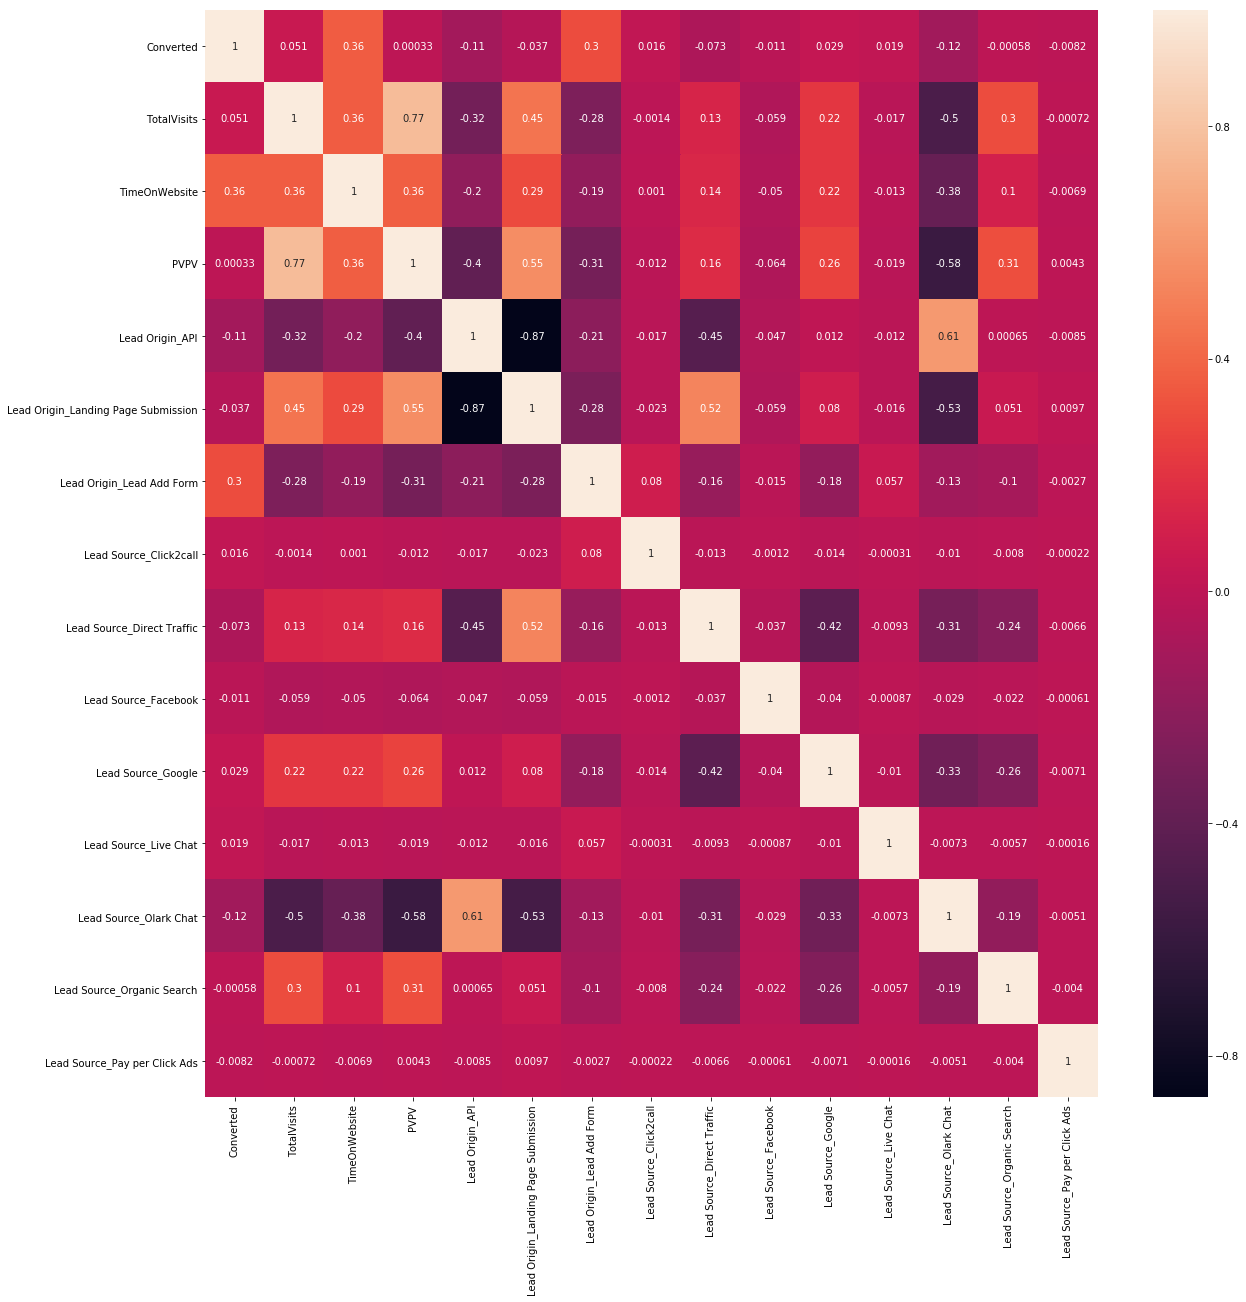

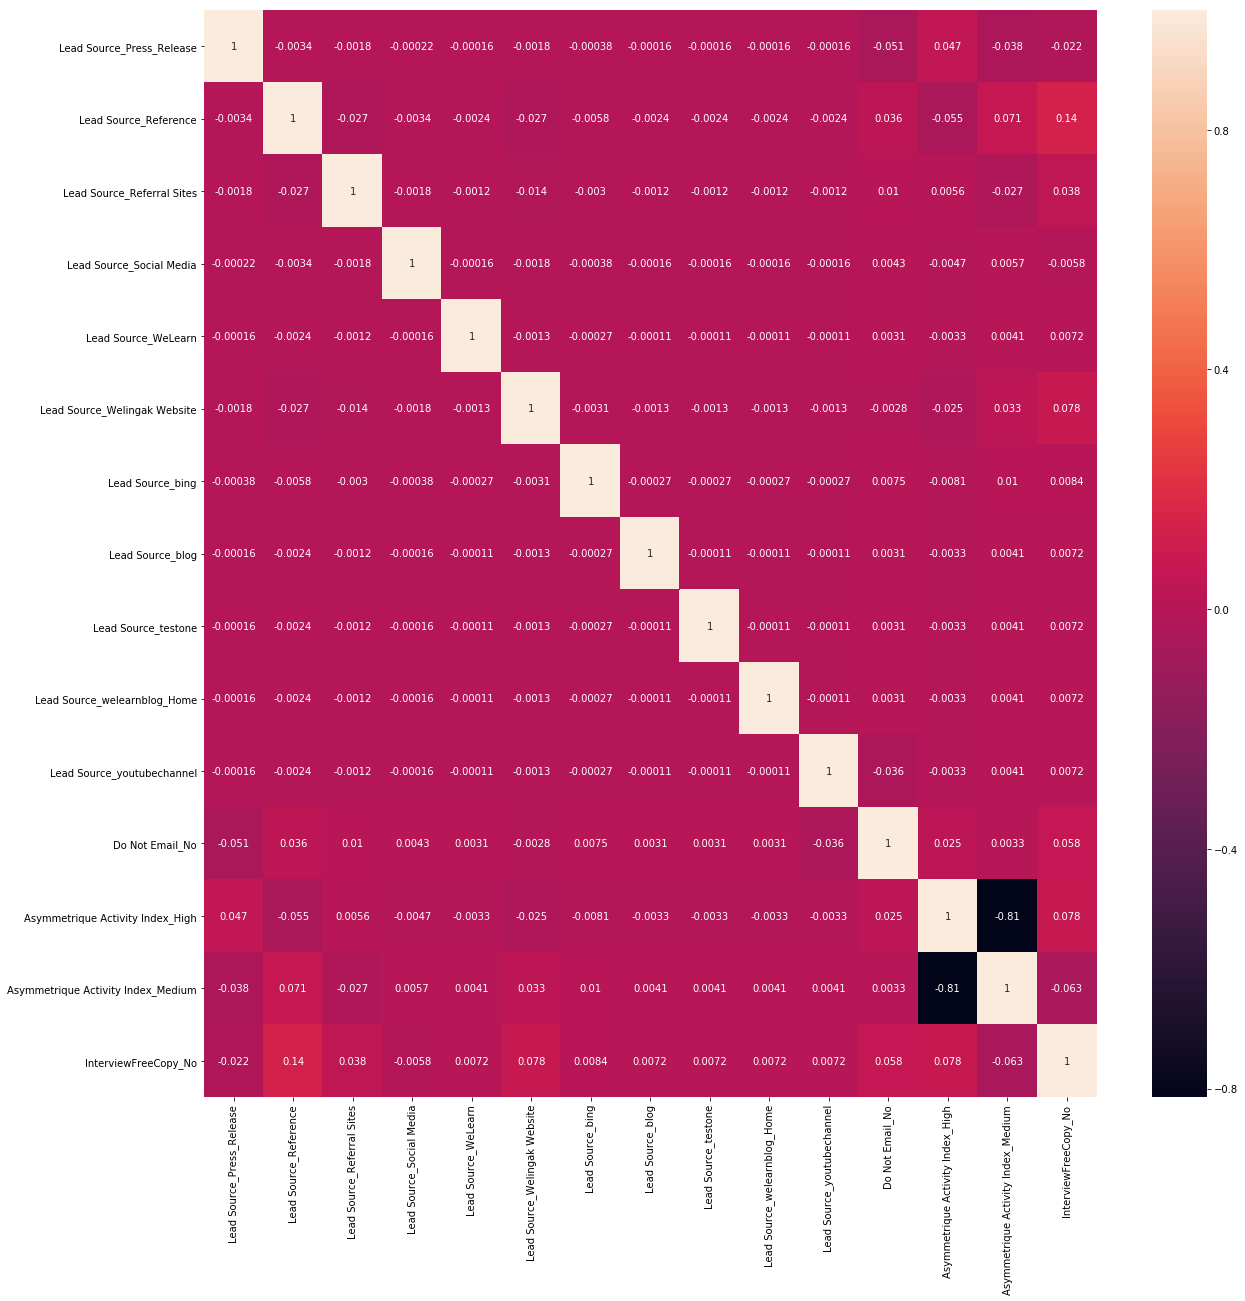

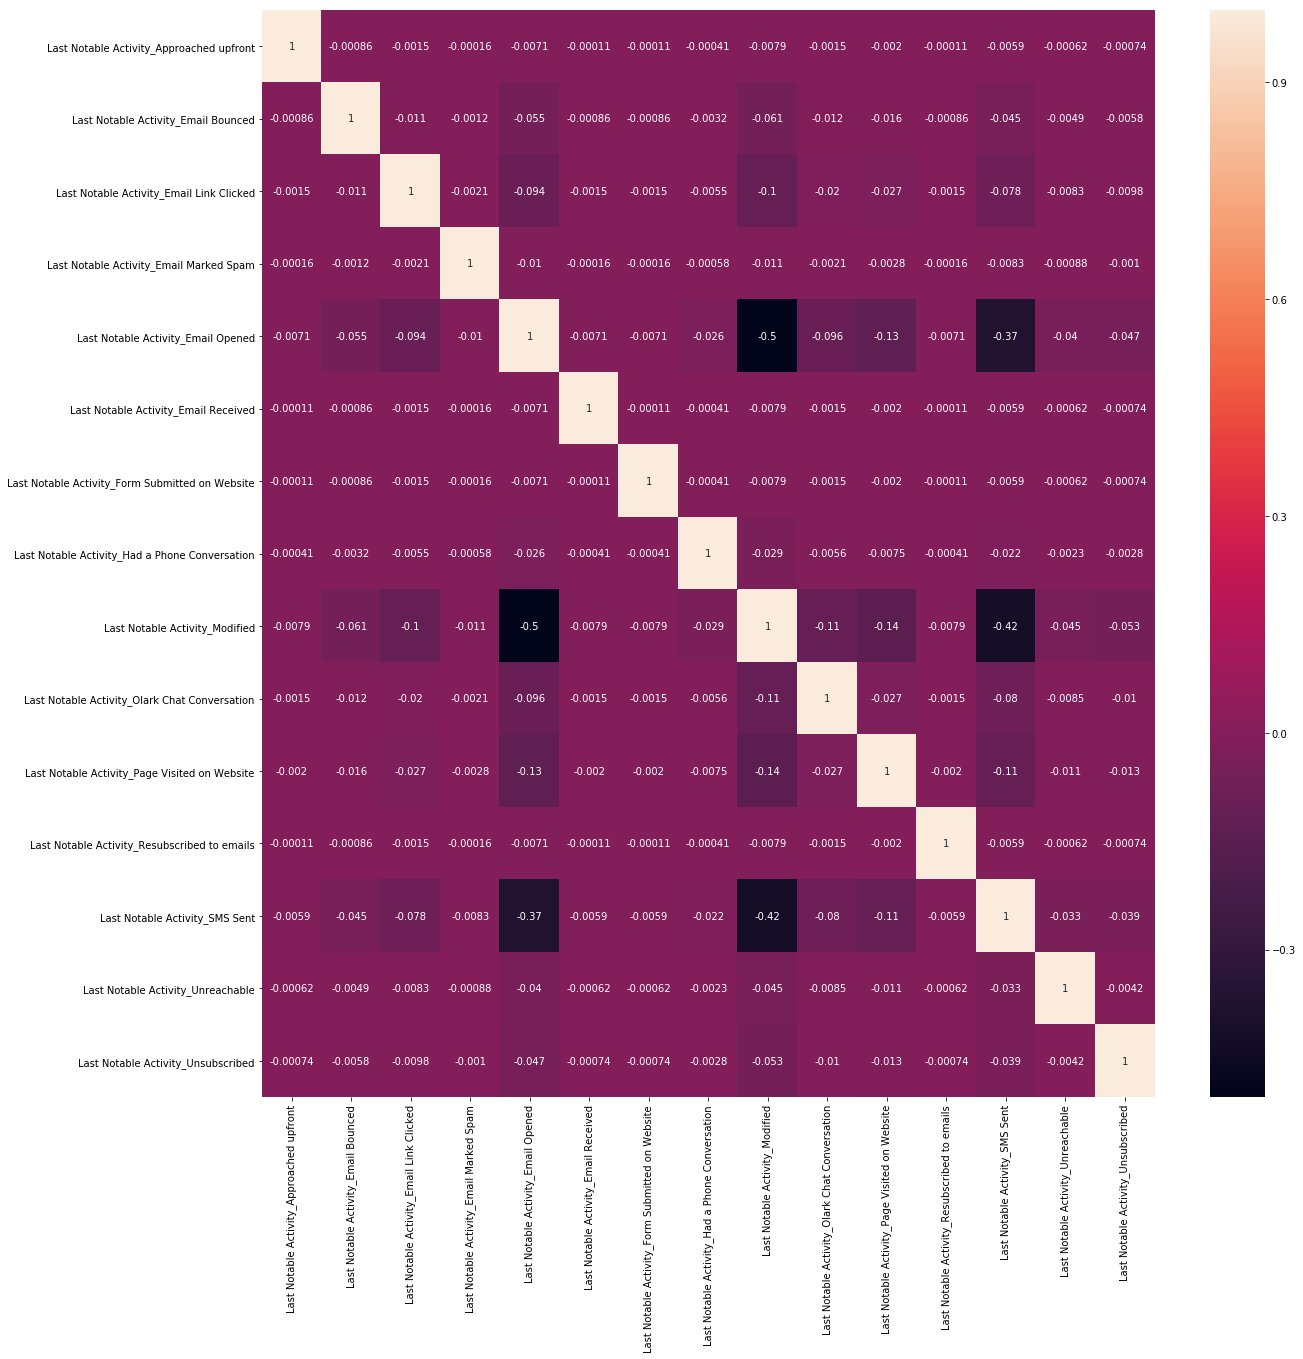

In [307]:
# Check the correlation matrix or heatmap . Dividing 45 variables in 3 sets of 15 variables for better visuals.
plt.figure(figsize = (20,20))
CorrDF=LeadDataDummy.iloc[:,0:15]
sns.heatmap(CorrDF.corr(),annot = True)
plt.show()

plt.figure(figsize = (20,20))
CorrDF=LeadDataDummy.iloc[:,15:30]
sns.heatmap(CorrDF.corr(),annot = True)
plt.show()

plt.figure(figsize = (20,20))
CorrDF=LeadDataDummy.iloc[:,30:45]
sns.heatmap(CorrDF.corr(),annot = True)
plt.show()

### Will drop one column for each highly correlated pair ( with correlation > 0.8)
### Pairs with correlation > 0.8 are :
    Asymmetrique Activity Index_Medium : Asymmetrique Activity Index_High
    Lead Origin_API : Lead Origin_Landing Page Submission 
    

In [308]:
# Drop columns 'Asymmetrique Activity Index_High' and 'Lead Origin_Landing Page Submission'
LeadDataDummy.drop(columns=['Asymmetrique Activity Index_High','Lead Origin_Landing Page Submission'],inplace=True)
LeadDataDummy.columns

Index(['Converted', 'TotalVisits', 'TimeOnWebsite', 'PVPV', 'Lead Origin_API',
       'Lead Origin_Lead Add Form', 'Lead Source_Click2call',
       'Lead Source_Direct Traffic', 'Lead Source_Facebook',
       'Lead Source_Google', 'Lead Source_Live Chat', 'Lead Source_Olark Chat',
       'Lead Source_Organic Search', 'Lead Source_Pay per Click Ads',
       'Lead Source_Press_Release', 'Lead Source_Reference',
       'Lead Source_Referral Sites', 'Lead Source_Social Media',
       'Lead Source_WeLearn', 'Lead Source_Welingak Website',
       'Lead Source_bing', 'Lead Source_blog', 'Lead Source_testone',
       'Lead Source_welearnblog_Home', 'Lead Source_youtubechannel',
       'Do Not Email_No', 'Asymmetrique Activity Index_Medium',
       'InterviewFreeCopy_No', 'Last Notable Activity_Approached upfront',
       'Last Notable Activity_Email Bounced',
       'Last Notable Activity_Email Link Clicked',
       'Last Notable Activity_Email Marked Spam',
       'Last Notable Activity_Email

### Test - Train split

In [309]:
# Splitting the data into train and test
X=LeadDataDummy.drop(['Converted'],axis=1)
y=LeadDataDummy['Converted']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, test_size=0.3, random_state=100)
print(X_train.shape , X_test.shape)

(6351, 42) (2723, 42)


### Scale the Data :

In [310]:
# Scale original variables TotalVisits, TimeOnWebSite , PVPV
scaler=StandardScaler()
X_train[['TotalVisits','TimeOnWebsite','PVPV']]=scaler.fit_transform(X_train[['TotalVisits','TimeOnWebsite','PVPV']])
X_train.head()

,TotalVisits,TimeOnWebsite,PVPV,Lead Origin_API,Lead Origin_Lead Add Form,Lead Source_Click2call,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,...,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed
3009,-0.432779,-0.160255,-0.155018,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1012,-0.432779,-0.540048,-0.155018,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9226,-1.150329,-0.888650,-1.265540,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4750,-0.432779,1.643304,-0.155018,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7987,0.643547,2.017593,0.122613,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [311]:
# Check the conversion rate
ConversionRate = (sum(LeadDataDummy['Converted'])/len(LeadDataDummy['Converted'].index))*100
print('Conversion rate is {0} %'.format(round(ConversionRate,2)))

Conversion rate is 37.86 %


### Start Model building

In [312]:
logm1=sm.GLM(y_train,sm.add_constant(X_train),family=sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6309
Model Family:                Binomial   Df Model:                           41
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2786.3
Date:                Mon, 06 Jan 2020   Deviance:                       5572.5
Time:                        18:34:03   Pearson chi2:                 6.57e+03
No. Iterations:                    25   Covariance Type:             nonrobust
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                              -8.3675   3.57e+05  -2.34e-05      1.000      -7e+05       7e+05
TotalVisits                                         0.3542      0.054      6.579      0.000       0.249       0.460
TimeOnWebsite                                       1.1501      0.040     28.884      0.000       1.072       1.228
PVPV                                               -0.2441      0.060     -4.038      0.000      -0.363      -0.126
Lead Origin_API                                     0.0989      0.103      0.961      0.337      -0.103       0.301
Lead Origin_Lead Add Form                          -0.2379      1.730     -0.138      0.891      -3.629       3.153
Lead Source_Click2call                            -17.1963    1.5e+04     -0.001      0.999   -2.95e+04    2.95e+04
Lead Source_Direct Traffic                        -20.3728    1.5e+04     -0.001      0.999   -2.95e+04    2.95e+04
Lead Source_Facebook                              -18.6223    1.5e+04     -0.001      0.999   -2.95e+04    2.95e+04
Lead Source_Google                                -20.0547    1.5e+04     -0.001      0.999   -2.95e+04    2.95e+04
Lead Source_Live Chat                               3.2277   3.25e+04   9.92e-05      1.000   -6.37e+04    6.37e+04
Lead Source_Olark Chat                            -19.1159    1.5e+04     -0.001      0.999   -2.95e+04    2.95e+04
Lead Source_Organic Search                        -20.3067    1.5e+04     -0.001      0.999   -2.95e+04    2.95e+04
Lead Source_Pay per Click Ads                     -40.7343   4.78e+04     -0.001      0.999   -9.37e+04    9.36e+04
Lead Source_Press_Release                         -41.6546   7.03e+04     -0.001      1.000   -1.38e+05    1.38e+05
Lead Source_Reference                             -15.4715    1.5e+04     -0.001      0.999   -2.95e+04    2.95e+04
Lead Source_Referral Sites                        -20.4726    1.5e+04     -0.001      0.999   -2.95e+04    2.95e+04
Lead Source_Social Media                          -18.5168    1.5e+04     -0.001      0.999   -2.95e+04    2.95e+04
Lead Source_WeLearn                              1.531e-09   2.68e-05   5.71e-05      1.000   -5.25e-05    5.25e-05
Lead Source_Welingak Website                      -13.8238    1.5e+04     -0.001      0.999   -2.95e+04    2.95e+04
Lead Source_bing                                  -19.7349    1.5e+04     -0.001      0.999   -2.95e+04    2.95e+04
Lead Source_blog                                  -46.6092    4.8e+05  -9.71e-05      1.000   -9.41e+05    9.41e+05
Lead Source_testone                               -46.7390   8.74e+05  -5.35e-05      1.000   -1.71e+06    1.71e+06
Lead Source_welearnblog_Home                      -45.6974   4.18e+05     -0.000      1.000    -8.2e+05     8.2e+05
Lead Source_youtubechannel    

### Lets use RFE to reduce the columns to 15 from 42

In [313]:
#Selecting features from RFE
logreg=LogisticRegression()  # LogisticRegression instance
rfe=RFE(logreg,15)           # Select 15 columns using RFE
rfe.fit(X_train,y_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=15, step=1, verbose=0)

In [314]:
# Columns selected by RFE
col = X_train.columns[rfe.support_]
col

Index(['TimeOnWebsite', 'Lead Origin_Lead Add Form',
       'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Lead Source_Reference',
       'Lead Source_Referral Sites', 'Lead Source_Welingak Website',
       'Do Not Email_No', 'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation',
       'Last Notable Activity_SMS Sent', 'Last Notable Activity_Unreachable',
       'Last Notable Activity_Unsubscribed'],
      dtype='object')

In [315]:
# Columns NOT selected by RFE
X_train.columns[~rfe.support_]

Index(['TotalVisits', 'PVPV', 'Lead Origin_API', 'Lead Source_Click2call',
       'Lead Source_Facebook', 'Lead Source_Live Chat',
       'Lead Source_Olark Chat', 'Lead Source_Pay per Click Ads',
       'Lead Source_Press_Release', 'Lead Source_Social Media',
       'Lead Source_WeLearn', 'Lead Source_bing', 'Lead Source_blog',
       'Lead Source_testone', 'Lead Source_welearnblog_Home',
       'Lead Source_youtubechannel', 'Asymmetrique Activity Index_Medium',
       'InterviewFreeCopy_No', 'Last Notable Activity_Approached upfront',
       'Last Notable Activity_Email Bounced',
       'Last Notable Activity_Email Link Clicked',
       'Last Notable Activity_Email Marked Spam',
       'Last Notable Activity_Email Opened',
       'Last Notable Activity_Email Received',
       'Last Notable Activity_Form Submitted on Website',
       'Last Notable Activity_Page Visited on Website',
       'Last Notable Activity_Resubscribed to emails'],
      dtype='object')

### Start building , evaluating , iterating till get optimal solution

In [316]:
# Build model using RFE selected columns
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6335
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2826.4
Date:                Mon, 06 Jan 2020   Deviance:                       5652.8
Time:                        18:34:10   Pearson chi2:                 6.61e+03
No. Iterations:                     7   Covariance Type:             nonrobust
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -1.6252      0.202     -8.032      0.000      -2.022      -1.229
TimeOnWebsite                                      1.1542      0.039     29.284      0.000       1.077       1.231
Lead Origin_Lead Add Form                          1.2683      0.939      1.351      0.177      -0.571       3.108
Lead Source_Direct Traffic                        -1.2255      0.110    -11.178      0.000      -1.440      -1.011
Lead Source_Google                                -0.8544      0.104     -8.250      0.000      -1.057      -0.651
Lead Source_Organic Search                        -1.0500      0.128     -8.219      0.000      -1.300      -0.800
Lead Source_Reference                              2.1225      0.960      2.210      0.027       0.240       4.005
Lead Source_Referral Sites                        -1.2212      0.316     -3.866      0.000      -1.840      -0.602
Lead Source_Welingak Website                       3.7091      1.186      3.127      0.002       1.384       6.034
Do Not Email_No                                    1.5963      0.182      8.750      0.000       1.239       1.954
Last Notable Activity_Had a Phone Conversation     3.2830      1.092      3.006      0.003       1.142       5.424
Last Notable Activity_Modified                    -0.7337      0.080     -9.119      0.000      -0.891      -0.576
Last Notable Activity_Olark Chat Conversation     -1.4590      0.313     -4.654      0.000      -2.073      -0.845
Last Notable Activity_SMS Sent                     1.4374      0.083     17.227      0.000       1.274       1.601
Last Notable Activity_Unreachable                  1.6822      0.465      3.618      0.000       0.771       2.594
Last Notable Activity_Unsubscribed                 1.4452      0.491      2.941      0.003       0.482       2.408
==================================================================================================================
"""

#### The p-value of column 'Lead Origin_Lead Add Form' is  large(>0.05)  and need to be dropped.

In [317]:
# Drop the column 'Lead Origin_Lead Add Form'
col=col.drop('Lead Origin_Lead Add Form',1)
col

Index(['TimeOnWebsite', 'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Lead Source_Reference',
       'Lead Source_Referral Sites', 'Lead Source_Welingak Website',
       'Do Not Email_No', 'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation',
       'Last Notable Activity_SMS Sent', 'Last Notable Activity_Unreachable',
       'Last Notable Activity_Unsubscribed'],
      dtype='object')

#### Next Iteration

In [318]:
# Make the model again with 14 columns/features
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6336
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2827.4
Date:                Mon, 06 Jan 2020   Deviance:                       5654.8
Time:                        18:34:10   Pearson chi2:                 6.61e+03
No. Iterations:                     7   Covariance Type:             nonrobust
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -1.6166      0.202     -7.995      0.000      -2.013      -1.220
TimeOnWebsite                                      1.1551      0.039     29.315      0.000       1.078       1.232
Lead Source_Direct Traffic                        -1.2353      0.109    -11.298      0.000      -1.450      -1.021
Lead Source_Google                                -0.8640      0.103     -8.368      0.000      -1.066      -0.662
Lead Source_Organic Search                        -1.0598      0.128     -8.310      0.000      -1.310      -0.810
Lead Source_Reference                              3.3825      0.227     14.875      0.000       2.937       3.828
Lead Source_Referral Sites                        -1.2307      0.316     -3.897      0.000      -1.850      -0.612
Lead Source_Welingak Website                       4.9695      0.732      6.786      0.000       3.534       6.405
Do Not Email_No                                    1.5974      0.182      8.756      0.000       1.240       1.955
Last Notable Activity_Had a Phone Conversation     3.2832      1.092      3.006      0.003       1.143       5.424
Last Notable Activity_Modified                    -0.7350      0.080     -9.138      0.000      -0.893      -0.577
Last Notable Activity_Olark Chat Conversation     -1.4650      0.313     -4.674      0.000      -2.079      -0.851
Last Notable Activity_SMS Sent                     1.4378      0.083     17.234      0.000       1.274       1.601
Last Notable Activity_Unreachable                  1.6814      0.465      3.616      0.000       0.770       2.593
Last Notable Activity_Unsubscribed                 1.4436      0.491      2.938      0.003       0.481       2.407
==================================================================================================================
"""

In [319]:
# Get the predicted values for train set
y_train_pred = res.predict(X_train_sm)
print(y_train_pred[:5])
print(y_train_pred.values[:5])

3009    0.191597
1012    0.030010
9226    0.144216
4750    0.889074
7987    0.584392
dtype: float64
[0.19159684 0.03001039 0.14421618 0.88907407 0.58439192]


#### Create Data Frame with predicted and actual conversions

In [320]:
# Create initial Data Frame
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'ConversionProb':y_train_pred.values})
y_train_pred_final['LeadID'] = y_train_pred.index
y_train_pred_final.head()

,Converted,ConversionProb,LeadID
0,0,0.191597,3009
1,0,0.030010,1012
2,0,0.144216,9226
3,1,0.889074,4750
4,1,0.584392,7987


In [321]:
# For start lets choose the threshold ConversionProb for conversion =0.4 . Create predicted column using this treshold
y_train_pred_final['Predicted'] = y_train_pred_final.ConversionProb.map(lambda x: 1 if x > 0.4 else 0)
y_train_pred_final.head()

,Converted,ConversionProb,LeadID,Predicted
0,0,0.191597,3009,0
1,0,0.030010,1012,0
2,0,0.144216,9226,0
3,1,0.889074,4750,1
4,1,0.584392,7987,1


In [322]:
# Get the confusion matrix and metrics like Accuracy and Sensitivity
confusion_matrix=metrics.confusion_matrix(y_train_pred_final.Converted,y_train_pred_final.Predicted)
print(confusion_matrix)

[[3216  689]
 [ 572 1874]]


In [323]:
# Assign confursion matrix values as TP,TN,FN,FP
TP = confusion_matrix[1,1] # true positive 
TN = confusion_matrix[0,0] # true negatives
FP = confusion_matrix[0,1] # false positives
FN = confusion_matrix[1,0] # false negatives

In [324]:
#print Accuracy and Sensitivity
print('Sensitivity:',TP / float(TP+FN))
print('Accuracy:',(TP+TN)/(TP+TN+FN+FP))

Sensitivity: 0.7661488143908421
Accuracy: 0.8014485907731066


In [325]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,Do Not Email_No,4.76
2,Lead Source_Google,2.54
1,Lead Source_Direct Traffic,2.11
9,Last Notable Activity_Modified,1.76
11,Last Notable Activity_SMS Sent,1.61
3,Lead Source_Organic Search,1.55
4,Lead Source_Reference,1.24
0,TimeOnWebsite,1.23
6,Lead Source_Welingak Website,1.07
5,Lead Source_Referral Sites,1.06


In [326]:
# Drop the column having highest VIF score 'Do Not Email_No'. Value is near 5 and also business wise NOT important
col=col.drop('Do Not Email_No',1)
col

Index(['TimeOnWebsite', 'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Lead Source_Reference',
       'Lead Source_Referral Sites', 'Lead Source_Welingak Website',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation',
       'Last Notable Activity_SMS Sent', 'Last Notable Activity_Unreachable',
       'Last Notable Activity_Unsubscribed'],
      dtype='object')

#### Next Iteration

In [327]:
# Lets build the model again and check for VIF
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6337
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2875.9
Date:                Mon, 06 Jan 2020   Deviance:                       5751.8
Time:                        18:34:13   Pearson chi2:                 6.70e+03
No. Iterations:                     7   Covariance Type:             nonrobust
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -0.0206      0.089     -0.232      0.816      -0.194       0.153
TimeOnWebsite                                      1.1607      0.039     29.760      0.000       1.084       1.237
Lead Source_Direct Traffic                        -1.3237      0.108    -12.224      0.000      -1.536      -1.111
Lead Source_Google                                -0.8736      0.103     -8.508      0.000      -1.075      -0.672
Lead Source_Organic Search                        -1.1309      0.126     -8.956      0.000      -1.378      -0.883
Lead Source_Reference                              3.3603      0.226     14.852      0.000       2.917       3.804
Lead Source_Referral Sites                        -1.2125      0.315     -3.851      0.000      -1.829      -0.595
Lead Source_Welingak Website                       4.7813      0.724      6.601      0.000       3.362       6.201
Last Notable Activity_Had a Phone Conversation     3.3178      1.094      3.032      0.002       1.173       5.462
Last Notable Activity_Modified                    -0.8140      0.080    -10.222      0.000      -0.970      -0.658
Last Notable Activity_Olark Chat Conversation     -1.5139      0.314     -4.828      0.000      -2.128      -0.899
Last Notable Activity_SMS Sent                     1.3729      0.082     16.711      0.000       1.212       1.534
Last Notable Activity_Unreachable                  1.6662      0.458      3.641      0.000       0.769       2.563
Last Notable Activity_Unsubscribed                -0.1187      0.457     -0.260      0.795      -1.015       0.778
==================================================================================================================
"""

In [328]:
# Get the predicted values for train set
y_train_pred = res.predict(X_train_sm)
print(y_train_pred[:5])
print(y_train_pred.values[:5])

3009    0.177958
1012    0.122273
9226    0.134000
4750    0.873922
7987    0.545775
dtype: float64
[0.17795785 0.12227317 0.13400048 0.87392226 0.54577539]


#### Create Data Frame with predicted and actual conversions

In [329]:
# Create initial Data Frame
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'ConversionProb':y_train_pred.values})
y_train_pred_final['LeadID'] = y_train_pred.index
y_train_pred_final.head()

,Converted,ConversionProb,LeadID
0,0,0.177958,3009
1,0,0.122273,1012
2,0,0.134000,9226
3,1,0.873922,4750
4,1,0.545775,7987


In [330]:
# For start lets choose the threshold ConversionProb for conversion =0.4 . Create predicted column using this treshold
y_train_pred_final['Predicted'] = y_train_pred_final.ConversionProb.map(lambda x: 1 if x > 0.4 else 0)
y_train_pred_final.head()

,Converted,ConversionProb,LeadID,Predicted
0,0,0.177958,3009,0
1,0,0.122273,1012,0
2,0,0.134000,9226,0
3,1,0.873922,4750,1
4,1,0.545775,7987,1


In [331]:
# Get the confusion matrix and metrics like Accuracy and Sensitivity
confusion_matrix=metrics.confusion_matrix(y_train_pred_final.Converted,y_train_pred_final.Predicted)
print(confusion_matrix)

[[3210  695]
 [ 597 1849]]


In [332]:
# Assign confursion matrix values as TP,TN,FN,FP
TP = confusion_matrix[1,1] # true positive 
TN = confusion_matrix[0,0] # true negatives
FP = confusion_matrix[0,1] # false positives
FN = confusion_matrix[1,0] # false negatives

In [333]:
#print Accuracy and Sensitivity
print('Sensitivity:',TP / float(TP+FN))
print('Accuracy:',(TP+TN)/(TP+TN+FN+FP))

Sensitivity: 0.7559280457890434
Accuracy: 0.7965674696898126


#### There is no significant drop in Accuracy and Sensitivity

####  The P-Value of 'Last Notable Activity_Unsubscribed' is very high , lets remove it and build the model again

In [334]:
# Drop column 'Last Notable Activity_Unsubscribed'
col=col.drop('Last Notable Activity_Unsubscribed',1)
col

Index(['TimeOnWebsite', 'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Lead Source_Reference',
       'Lead Source_Referral Sites', 'Lead Source_Welingak Website',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation',
       'Last Notable Activity_SMS Sent', 'Last Notable Activity_Unreachable'],
      dtype='object')

#### Next Iteration

In [335]:
# Lets build the model again and check for VIF
X_train_sm = sm.add_constant(X_train[col])
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6338
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2875.9
Date:                Mon, 06 Jan 2020   Deviance:                       5751.8
Time:                        18:34:15   Pearson chi2:                 6.70e+03
No. Iterations:                     7   Covariance Type:             nonrobust
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -0.0224      0.088     -0.253      0.800      -0.195       0.151
TimeOnWebsite                                      1.1605      0.039     29.761      0.000       1.084       1.237
Lead Source_Direct Traffic                        -1.3231      0.108    -12.222      0.000      -1.535      -1.111
Lead Source_Google                                -0.8730      0.103     -8.505      0.000      -1.074      -0.672
Lead Source_Organic Search                        -1.1310      0.126     -8.957      0.000      -1.378      -0.884
Lead Source_Reference                              3.3610      0.226     14.856      0.000       2.918       3.804
Lead Source_Referral Sites                        -1.2141      0.315     -3.855      0.000      -1.831      -0.597
Lead Source_Welingak Website                       4.7819      0.724      6.602      0.000       3.362       6.202
Last Notable Activity_Had a Phone Conversation     3.3190      1.094      3.033      0.002       1.174       5.464
Last Notable Activity_Modified                    -0.8125      0.079    -10.231      0.000      -0.968      -0.657
Last Notable Activity_Olark Chat Conversation     -1.5122      0.313     -4.824      0.000      -2.127      -0.898
Last Notable Activity_SMS Sent                     1.3744      0.082     16.767      0.000       1.214       1.535
Last Notable Activity_Unreachable                  1.6677      0.458      3.644      0.000       0.771       2.565
==================================================================================================================
"""

In [336]:
# Get the predicted values for train set
y_train_pred = res.predict(X_train_sm)
print(y_train_pred[:5])
print(y_train_pred.values[:5])

3009    0.177784
1012    0.122154
9226    0.133987
4750    0.873913
7987    0.545754
dtype: float64
[0.17778393 0.12215356 0.13398738 0.87391293 0.54575414]


#### Create Data Frame with predicted and actual conversions

In [337]:
# Create initial Data Frame
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'ConversionProb':y_train_pred.values})
y_train_pred_final['LeadID'] = y_train_pred.index
y_train_pred_final.head()

,Converted,ConversionProb,LeadID
0,0,0.177784,3009
1,0,0.122154,1012
2,0,0.133987,9226
3,1,0.873913,4750
4,1,0.545754,7987


In [338]:
# For start lets choose the threshold ConversionProb for conversion =0.4 . Create predicted column using this treshold
y_train_pred_final['Predicted'] = y_train_pred_final.ConversionProb.map(lambda x: 1 if x > 0.4 else 0)
y_train_pred_final.head()

,Converted,ConversionProb,LeadID,Predicted
0,0,0.177784,3009,0
1,0,0.122154,1012,0
2,0,0.133987,9226,0
3,1,0.873913,4750,1
4,1,0.545754,7987,1


In [339]:
# Get the confusion matrix and metrics like Accuracy and Sensitivity
confusion_matrix=metrics.confusion_matrix(y_train_pred_final.Converted,y_train_pred_final.Predicted)
print(confusion_matrix)

[[3211  694]
 [ 598 1848]]


In [340]:
# Assign confursion matrix values as TP,TN,FN,FP
TP = confusion_matrix[1,1] # true positive 
TN = confusion_matrix[0,0] # true negatives
FP = confusion_matrix[0,1] # false positives
FN = confusion_matrix[1,0] # false negatives

In [341]:
#print Accuracy and Sensitivity
print('Sensitivity:',TP / float(TP+FN))
print('Accuracy:',(TP+TN)/(TP+TN+FN+FP))

Sensitivity: 0.7555192150449714
Accuracy: 0.7965674696898126


#### There is no significant drop in Accuracy and Sensitivity . The P-values look good.
#### Lets check VIF again

In [342]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
8,Last Notable Activity_Modified,1.60
10,Last Notable Activity_SMS Sent,1.48
2,Lead Source_Google,1.47
1,Lead Source_Direct Traffic,1.37
3,Lead Source_Organic Search,1.20
0,TimeOnWebsite,1.18
4,Lead Source_Reference,1.11
6,Lead Source_Welingak Website,1.04
5,Lead Source_Referral Sites,1.02
9,Last Notable Activity_Olark Chat Conversation,1.01


#### The highest value of VIF is less than 5 , hence there is no need to drop features further


#### Lets try to adjust threshold such that  both Accuracy  near 0.8 and Sensitivity greater than 0.8

In [343]:
# Adjust threshold ConversionProb for conversion =0.32(reached this value after 5 trials) .
#Create predicted column using this treshold
y_train_pred_final['Predicted'] = y_train_pred_final.ConversionProb.map(lambda x: 1 if x > 0.32 else 0)
y_train_pred_final.head()

,Converted,ConversionProb,LeadID,Predicted
0,0,0.177784,3009,0
1,0,0.122154,1012,0
2,0,0.133987,9226,0
3,1,0.873913,4750,1
4,1,0.545754,7987,1


In [344]:
# Get the confusion matrix and metrics like Accuracy and Sensitivity
confusion_matrix=metrics.confusion_matrix(y_train_pred_final.Converted,y_train_pred_final.Predicted)
print(confusion_matrix)

[[3023  882]
 [ 461 1985]]


In [345]:
# Assign confursion matrix values as TP,TN,FN,FP
TP = confusion_matrix[1,1] # true positive 
TN = confusion_matrix[0,0] # true negatives
FP = confusion_matrix[0,1] # false positives
FN = confusion_matrix[1,0] # false negatives

In [346]:
#print Accuracy and Sensitivity
print('Sensitivity:',TP / float(TP+FN))
print('Accuracy:',(TP+TN)/(TP+TN+FN+FP))

Sensitivity: 0.8115290269828291
Accuracy: 0.7885372382301999


#### After 5  trials, the threshold of 0.32 gives both accuracy near 0.8 and Sensitivity  >  0.8

### Plot the ROC curve

In [347]:
# function for plotting RIC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

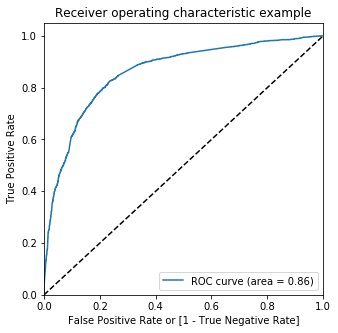

In [348]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.ConversionProb)

### Finding optimal threshold point

In [349]:
# Let's add columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.ConversionProb.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,ConversionProb,LeadID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.177784,3009,0,1,1,0,0,0,0,0,0,0,0
1,0,0.122154,1012,0,1,1,0,0,0,0,0,0,0,0
2,0,0.133987,9226,0,1,1,0,0,0,0,0,0,0,0
3,1,0.873913,4750,1,1,1,1,1,1,1,1,1,1,0
4,1,0.545754,7987,1,1,1,1,1,1,1,0,0,0,0


In [350]:
# Now let's create a chart for accuracy , sensitivity and specificity for various probability cutoffs.

cutoff_df = pd.DataFrame( columns = ['prob_treshold','accuracy','sensitivity','specificity'])
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total=sum(sum(cm))
    accuracy = (cm[0,0]+cm[1,1])/total
    
    speci = cm[0,0]/(cm[0,0]+cm[0,1])
    sensi = cm[1,1]/(cm[1,0]+cm[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
cutoff_df

,prob_treshold,accuracy,sensitivity,specificity
0.0,0.0,0.385136,1.000000,0.000000
0.1,0.1,0.530940,0.970973,0.255314
0.2,0.2,0.726185,0.903925,0.614853
0.3,0.3,0.787593,0.825429,0.763892
0.4,0.4,0.796567,0.755519,0.822279
0.5,0.5,0.798457,0.668847,0.879641
0.6,0.6,0.772004,0.536795,0.919334
0.7,0.7,0.759251,0.461979,0.945455
0.8,0.8,0.736262,0.366312,0.967990
0.9,0.9,0.694536,0.229763,0.985659


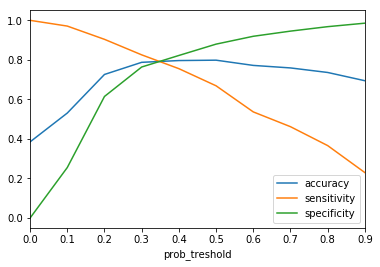

In [351]:
# Let's plot accuracy sensitivity and specificity for various probability thresholds.
cutoff_df.plot.line(x='prob_treshold', y=['accuracy','sensitivity','specificity'])
plt.show()

#### As per above chart Probability threshold of 0.34 seems best for balancing trade-offs between senisitivity, accuracy and specificity .
#### But experimentally 0.31 is the best threshold till now , as we focus on Sensitivity greater than 0.8

#### As per suggested graph , lets again try out thresholds from 0.31 to 0.34

In [352]:
# Try with threshold 0.31 to 0.34
y_train_pred_final['Predicted'] = y_train_pred_final.ConversionProb.map(lambda x: 1 if x > 0.34 else 0)
y_train_pred_final.head()

,Converted,ConversionProb,LeadID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.177784,3009,0,1,1,0,0,0,0,0,0,0,0
1,0,0.122154,1012,0,1,1,0,0,0,0,0,0,0,0
2,0,0.133987,9226,0,1,1,0,0,0,0,0,0,0,0
3,1,0.873913,4750,1,1,1,1,1,1,1,1,1,1,0
4,1,0.545754,7987,1,1,1,1,1,1,1,0,0,0,0


In [353]:
# Get the confusion matrix and metrics like Accuracy and Sensitivity
confusion_matrix=metrics.confusion_matrix(y_train_pred_final.Converted,y_train_pred_final.Predicted)
print(confusion_matrix)

[[3068  837]
 [ 489 1957]]


In [354]:
# Assign confursion matrix values as TP,TN,FN,FP
TP = confusion_matrix[1,1] # true positive 
TN = confusion_matrix[0,0] # true negatives
FP = confusion_matrix[0,1] # false positives
FN = confusion_matrix[1,0] # false negatives

In [355]:
#print Accuracy and Sensitivity
print('Sensitivity:',TP / float(TP+FN))
print('Accuracy:',(TP+TN)/(TP+TN+FN+FP))

Sensitivity: 0.8000817661488144
Accuracy: 0.7912139820500709


#### After fine tuning threshold , I arrive threshold probability of 0.31 to be optimum.
#### Sensitivity is > 0.8 as desired by CEO , and also  greatest for threshold=0.31 ( in range of 0.31 to 0.34)
#### Accuracy is near to 0.8 for given value of sensitivity ( Its near 0.8 for all thresholds )

### Make predictions on Test Set

In [356]:
# Scale the test set columns based on train set scaler
X_test[['TotalVisits','TimeOnWebsite','PVPV']]=scaler.fit_transform(X_test[['TotalVisits','TimeOnWebsite','PVPV']])
X_test.head()

,TotalVisits,TimeOnWebsite,PVPV,Lead Origin_API,Lead Origin_Lead Add Form,Lead Source_Click2call,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,...,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed
3271,0.304501,-0.591008,0.998931,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1490,0.666261,1.894051,1.564920,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7936,-0.419021,-0.743117,-0.133048,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4216,-1.142542,-0.878732,-1.265027,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3830,1.751544,-0.578179,2.130909,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [357]:
# Reduce test columns as per train set
X_test=X_test[col]
X_test.head()

,TimeOnWebsite,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable
3271,-0.591008,0,1,0,0,0,0,0,0,0,0,0
1490,1.894051,1,0,0,0,0,0,0,0,0,0,0
7936,-0.743117,0,1,0,0,0,0,0,0,0,0,0
4216,-0.878732,0,0,0,1,0,0,0,1,0,0,0
3830,-0.578179,0,0,1,0,0,0,0,0,0,0,0


In [358]:
# Make prediction data set on test set

X_test_sm = sm.add_constant(X_test)  # Add constant to X_test
y_test_pred = res.predict(X_test_sm) # Make predictions of probabilities on test set based on last model logm5
y_test_pred[:5]

3271    0.170617
1490    0.701119
7936    0.147068
4216    0.818516
3830    0.138910
dtype: float64

In [359]:
# Convert y_test_pred into a Data Frame
y_test_pred_df=pd.DataFrame(y_test_pred)
y_test_pred_df.head()

,0
3271,0.170617
1490,0.701119
7936,0.147068
4216,0.818516
3830,0.138910


In [360]:
# Convert y_test (test set) also into Data Frame
y_test_df=pd.DataFrame(y_test)
y_test_df.head()

,Converted
3271,0
1490,1
7936,0
4216,1
3830,0


In [361]:
# Cocatenate the above predicted and test set
y_pred_final=pd.concat([y_test_pred_df,y_test_df],axis=1)
y_pred_final.head()

,0,Converted
3271,0.170617,0
1490,0.701119,1
7936,0.147068,0
4216,0.818516,1
3830,0.138910,0


In [362]:
# Clean the y_pred_final with column names and adding index as column(LeadID)
y_pred_final= y_pred_final.rename(columns={ 0 : 'ConversionProb'})  # Rename 0 column
y_pred_final['LeadID']=y_pred_final.index  # Create index column LeadID
y_pred_final = y_pred_final.reindex_axis(['LeadID','Converted','ConversionProb'], axis=1) # Re-arrange columns
y_pred_final.reset_index(drop=True, inplace=True)  # Re-Set index
y_pred_final.head()

,LeadID,Converted,ConversionProb
0,3271,0,0.170617
1,1490,1,0.701119
2,7936,0,0.147068
3,4216,1,0.818516
4,3830,0,0.138910


In [363]:
# Add column for Predicted conversion as per threshold=0.31
y_pred_final['Predicted'] = y_pred_final.ConversionProb.map(lambda x: 1 if x > 0.31 else 0)
y_pred_final.head()

,LeadID,Converted,ConversionProb,Predicted
0,3271,0,0.170617,0
1,1490,1,0.701119,1
2,7936,0,0.147068,0
3,4216,1,0.818516,1
4,3830,0,0.138910,0


In [364]:
# Get the confusion matrix and metrics like Accuracy and Sensitivity
confusion_matrix=metrics.confusion_matrix(y_pred_final.Converted,y_pred_final.Predicted)
print(confusion_matrix)

[[1334  400]
 [ 198  791]]


In [365]:
# Assign confursion matrix values as TP,TN,FN,FP
TP = confusion_matrix[1,1] # true positive 
TN = confusion_matrix[0,0] # true negatives
FP = confusion_matrix[0,1] # false positives
FN = confusion_matrix[1,0] # false negatives

In [366]:
#print Accuracy ,Sensitivity, Specificity , Precision 
print('Sensitivity or Recall:',round(TP / float(TP+FN),2))
print('Accuracy:',round((TP+TN)/(TP+TN+FN+FP),2))
print('Specificity:',round(TN / float(TN+FP),2))
print('Precision:',round(TP / float(TP+FP),2))

Sensitivity or Recall: 0.8
Accuracy: 0.78
Specificity: 0.77
Precision: 0.66


### Hence we have now reached our final model(logm5) and Probability Threshold(0.31)
### Predicted Sensitivity is 0.8 as required by CEO , ie now conversion rate should be greater than 80%
### Accuracy and Specificity numbers are good enough keeping in mind we need to have sensitivity above 0.8
### Precision is not that high(0.66) , but thats a trade off we accept for high Recall or Sensitivity